In [1]:
import sys
sys.path.append('../')

In [2]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
from pathlib import Path

import torch
from PIL import Image
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from tqdm import tqdm

from models.stylegan2_generator import StyleGAN2Generator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test torch in GPU
x = torch.randn((1, 1)).to(device)
print(2 * x)

/home/gregschuit/projects/Hammer/.venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([[1.6462]], device='cuda:0')


In [4]:
DATA_DIR = Path('../.data/synthetic')
# HAMMER_WORK_DIRS = Path('../work_dirs/')
HAMMER_WORK_DIRS = Path('/mnt/data/gregschuit/work_dirs/')

In [5]:
paths = {
    'stylegan2_imagenome256_pa_resized': HAMMER_WORK_DIRS / 'stylegan2_imagenome256_pa_resized/checkpoints/best-fid50k_full-checkpoint-064000.pth',
    'c_stylegan2_imagenome256_device_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_device_pa_resized/checkpoints/best-fid50k_full-checkpoint-064000.pth',
    'c_stylegan2_imagenome256_lung_opacity_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_lung_opacity_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'c_stylegan2_imagenome256_atelectasis_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_atelectasis_pa_resized/checkpoints/best-fid50k_full-checkpoint-070400.pth',
    'c_stylegan2_imagenome256_enlarged_cardiac_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_enlarged_cardiac_pa_resized/checkpoints/best-fid50k_full-checkpoint-070400.pth',
    'c_stylegan2_imagenome256_pleural_effusion_pa_resized': HAMMER_WORK_DIRS / 'c_stylegan2_imagenome256_pleural_effusion_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w10': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w10/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w20': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w20/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w40': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w40/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w60': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w60/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w80': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w80/checkpoints/best-fid50k_full-checkpoint-070400.pth',

    'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_softbb_w40': HAMMER_WORK_DIRS / 'r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_softbb_w40/checkpoints/best-fid50k_full-checkpoint-075000.pth',
}

def load_generator(path):
    checkpoint = torch.load(path, map_location='cpu')
    init_kwargs = checkpoint['model_kwargs_init']['generator_smooth']
    del init_kwargs['model_type']
    model_kwargs_val = checkpoint['model_kwargs_val']['generator_smooth']
    generator = StyleGAN2Generator(**init_kwargs)
    generator.load_state_dict(checkpoint['models']['generator_smooth'])
    generator.eval()
    return generator, model_kwargs_val


def generate_images(generator, label, batch_size, model_kwargs, device='cpu'):
    """Uses the generator to generate a batch of images.

    Args:
        generator (StyleGAN2Generator): The generator to use.
        label (List[int]): The label to use in one-hot encoding. This list will be 
            repeated to match the batch size.
        batch_size (int): The number of images to generate.
        model_kwargs (dict): The model kwargs to be passed to the model on inference.

    """
    codes = torch.randn((batch_size, 512)).to(device)
    labels = torch.tensor([label] * batch_size).to(device)
    with torch.no_grad():
        out = generator(codes, label=labels, **model_kwargs)
    return out['image'], out['z'], out['w'], out['wp']


def process_generated_tensor(img_tensor: torch.Tensor) -> Image:
    """Converts a generated image tensor to a PIL image.

    The image tensor is expected to be approx. in the range [-1, 1], as is the case
    with the StyleGAN2Generator output.

    Args:
        img_tensor (torch.Tensor): The image tensor to convert.

    Returns:
        PIL.Image: The converted image.

    """
    _min, _max = -1, 1
    img_tensor = torch.clamp(img_tensor, _min, _max)
    img_tensor = (img_tensor - _min) / (_max - _min)
    pil_image = to_pil_image(img_tensor)
    return pil_image

In [6]:
sys.path.append('../../thesis/src/')

In [7]:
from cxr_region_based_cf.gan_inversion.chexplaining_source.model import Encoder

In [14]:
encoder = Encoder(256)
encoder.load_state_dict(
    torch.load(
        '/home/gregschuit/projects/thesis/'
        'gan-inv-enc=chexplain_gan-model=r_c_stylegan2_imagenome_w10_enlarged_cardiac-lr=0.001-epoch-4.pth'
    )
)

<All keys matched successfully>

In [11]:
generator, model_kwargs = load_generator(paths['r_c_stylegan2_imagenome256_enlarged_cardiac_pa_resized_w10'])

In [13]:
out = generate_images(generator, [1, 0], 2, model_kwargs)

In [22]:

images = out[0]
image = process_generated_tensor(images[0])

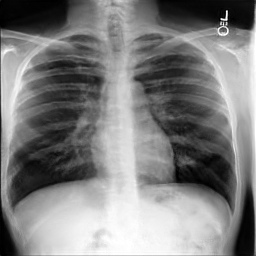

In [23]:
image

In [37]:
pil_to_tensor(image.convert('RGB'))

tensor([[[ 27,   6,   1,  ...,  18,  45,  67],
         [  9,   0,   0,  ...,  17,  31,  52],
         [  1,   0,   2,  ...,  18,  38,  60],
         ...,
         [  5,   0,   1,  ...,  35,  95, 125],
         [  6,   0,   0,  ...,  36,  91, 117],
         [ 27,   5,   0,  ...,  48,  78,  98]],

        [[ 27,   6,   1,  ...,  18,  45,  67],
         [  9,   0,   0,  ...,  17,  31,  52],
         [  1,   0,   2,  ...,  18,  38,  60],
         ...,
         [  5,   0,   1,  ...,  35,  95, 125],
         [  6,   0,   0,  ...,  36,  91, 117],
         [ 27,   5,   0,  ...,  48,  78,  98]],

        [[ 27,   6,   1,  ...,  18,  45,  67],
         [  9,   0,   0,  ...,  17,  31,  52],
         [  1,   0,   2,  ...,  18,  38,  60],
         ...,
         [  5,   0,   1,  ...,  35,  95, 125],
         [  6,   0,   0,  ...,  36,  91, 117],
         [ 27,   5,   0,  ...,  48,  78,  98]]], dtype=torch.uint8)

In [26]:
from torchvision.transforms.functional import pil_to_tensor

torch.Size([1, 3, 256, 256])

In [43]:
processed = image.convert('RGB')
batch_tensor = pil_to_tensor(processed).reshape(1, 3, 256, 256)

batch_tensor = torch.tensor(batch_tensor, dtype=torch.float32)

In [45]:
z_emb = encoder(batch_tensor)

In [46]:
z_emb.shape

torch.Size([1, 512])

In [48]:
codes = z_emb
labels = torch.tensor([[1, 0]] * 1)
with torch.no_grad():
    out_recon = generator(codes, label=labels, **model_kwargs)

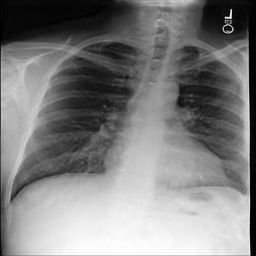

In [51]:
process_generated_tensor(out_recon['image'][0])